This is a notebook with an example of the simulations carried out in https://arxiv.org/abs/2312.08502. We will use the Hydrogen molecule for this example. 

In [9]:
#import libraries
import tequila as tq
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
#initialize a list of bond-lengths we will consider here
equilibrium_bl = 0.741
bond_lengths = [0.441, 0.541, 0.641, 0.741, 0.841, 0.941, 1.041, 1.141]
bond_lengths.extend([i*0.25 for i in range(4,21)])
bond_lengths.sort()

print("We are considering the following configurations:", bond_lengths)

We are considering the following configurations: [0.441, 0.541, 0.641, 0.741, 0.841, 0.941, 1.0, 1.041, 1.141, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]


In [3]:
#get Hamiltonian and commuting groups for a molecular configuration

Hamiltonians = []
Diag_Hamiltonians = []

for bond in bond_lengths:
    file = open("../Hamiltonians/H2/H2_Hamiltonian_for_bond_length_{0}.pickle".format(bond),'rb')
    mol_Ham = pickle.load(file)
    file.close()
    
    print("The Hamiltonian at bond length - {0} - is: {1}".format(bond, mol_Ham))
    
    file = open("../circuits_and_groups/H2/H2_groups_and_circuits_for_bond_length_{0}.pickle".format(bond),'rb')
    z_representation, groups, circuits = pickle.load(file)
    file.close()
    
    print("The groups at bond length - {0} - is:".format(bond))
    print("\t Commuting groups:", groups)
    print("\t Diagonal representations:")
    for z_rep, circ in z_representation:
        #print("Clifford Circuit:", tq.draw(circ, backend="cirq"))
        print("\t \t",z_rep)
        
    Hamiltonians.append(mol_Ham)
    Diag_Hamiltonians.append(z_representation)


The Hamiltonian at bond length - 0.441 - is: +0.5752+0.2263Z(0)+0.2263Z(1)-0.4172Z(2)-0.4172Z(3)+0.1825Z(0)Z(1)+0.0416Y(0)X(1)X(2)Y(3)-0.0416Y(0)Y(1)X(2)X(3)-0.0416X(0)X(1)Y(2)Y(3)+0.0416X(0)Y(1)Y(2)X(3)+0.1379Z(0)Z(2)+0.1795Z(0)Z(3)+0.1795Z(1)Z(2)+0.1379Z(1)Z(3)+0.1893Z(2)Z(3)
The groups at bond length - 0.441 - is:
	 Commuting groups: [[+0.5752, +0.2263Z(0), +0.2263Z(1), -0.4172Z(2), -0.4172Z(3), +0.1825Z(0)Z(1), +0.1379Z(0)Z(2), +0.1795Z(0)Z(3), +0.1795Z(1)Z(2), +0.1379Z(1)Z(3), +0.1893Z(2)Z(3)], [+0.0416Y(0)X(1)X(2)Y(3), -0.0416Y(0)Y(1)X(2)X(3), -0.0416X(0)X(1)Y(2)Y(3), +0.0416X(0)Y(1)Y(2)X(3)]]
	 Diagonal representations:
	 	 +0.5752+0.2263Z(0)+0.2263Z(1)-0.4172Z(2)-0.4172Z(3)+0.1825Z(0)Z(1)+0.1379Z(0)Z(2)+0.1795Z(0)Z(3)+0.1795Z(1)Z(2)+0.1379Z(1)Z(3)+0.1893Z(2)Z(3)
	 	 -0.0416Z(0)Z(3)+0.0416Z(0)Z(1)Z(3)+0.0416Z(2)Z(3)-0.0416Z(1)Z(2)Z(3)
The Hamiltonian at bond length - 0.541 - is: +0.2675+0.2058Z(0)+0.2058Z(1)-0.3387Z(2)-0.3387Z(3)+0.1781Z(0)Z(1)+0.0427Y(0)X(1)X(2)Y(3)-0.0427Y(0)Y

In [4]:
#let's calculate the ground state energies of the molecule at the different configurations
FCI_eners = []

for Ham in Hamiltonians:
    v,vv = np.linalg.eigh(Ham.to_matrix())
    FCI_eners.append(v[0])
    
print("The exact ground state energies of the molecules are:", FCI_eners)

The exact ground state energies of the molecules are: [-0.9855788541974305, -1.0870363833428838, -1.1280620237562355, -1.1372744055258714, -1.1295722450761354, -1.1130821615989959, -1.1011503301329568, -1.0923201201309294, -1.0699565851515562, -1.0457831444222825, -0.9981493533579184, -0.9663345447009661, -0.9486411121296494, -0.9399817051762288, -0.9360549199436622, -0.934348987741704, -0.9336318445559844, -0.9333412807063712, -0.9332284055492808, -0.93318638952978, -0.9331713618435846, -0.9331661854734714, -0.9331644700904957, -0.9331639259188951, -0.9331637619303776]


In [5]:
#Now we construct the single-code ansatz and carry optimization
num_qubits = 4

HF_ener = []
vqe_with_SCA = []

for Ham, z_rep in zip(Hamiltonians, Diag_Hamiltonians):
    min_ener = 0.
    found_state = False
    min_eigen_state_circuit = None
    
    for ham_ in z_rep:
        #here we cheat and do diagonalization instead of running VQE
        #finding the ground state of the diagonal hamitonian
        v,vv = np.linalg.eigh(ham_[0].to_matrix())
        energy = v[0]
        state = str(tq.QubitWaveFunction(vv[:,0]))
        state=state.split(">")[0]
        if "|" in state:
            state = state.split("|")[1]
                    
        if not found_state:
            min_ener = energy
            state = tq.BitString.from_binary(state)
            min_eigen_state_circuit = sum([tq.gates.X(q) for q,x in enumerate(state.array) if x == 1], tq.QCircuit())
            min_eigen_state_circuit += ham_[1].dagger()
            found_state = True
        else:
            if min_ener > energy:
                min_ener = energy
                state = tq.BitString.from_binary(state)
                min_eigen_state_circuit = sum([tq.gates.X(q) for q,x in enumerate(state.array) if x == 1], tq.QCircuit())  
                min_eigen_state_circuit += ham_[1].dagger()
                
    #simulating reference state
    ref = tq.QCircuit()    
    ref += tq.gates.X(0)
    ref += tq.gates.X(1)
    Exp = tq.ExpectationValue(U=ref, H= Ham)
    energy = tq.simulate(Exp, backend="qulacs")
    #print(energy)
    HF_ener.append(energy)
    
    Exp = tq.ExpectationValue(U=min_eigen_state_circuit, H= Ham)
    energy = tq.simulate(Exp,  backend="qulacs")
    #print(energy)
    vqe_with_SCA.append(energy)
    
print("Hartree-Fock energy:", HF_ener)

print("Energy from VQE with SCA:", vqe_with_SCA)

Hartree-Fock energy: [-0.9748875762662106, -1.0737238054577205, -1.1114819793727473, -1.1167061372172085, -1.1041978595865747, -1.0819500437996066, -1.0661086491853156, -1.0543139854719237, -1.0237931231830395, -0.989113813901707, -0.9108735543822688, -0.8413485982435203, -0.7837926540830396, -0.7381688270743743, -0.7029435995786047, -0.6761723103422429, -0.6560482510473122, -0.6410288555348156, -0.6298201100573617, -0.6213702691070155, -0.6148699739991873, -0.6097312576565607, -0.6055459396685837, -0.6020384516384962, -0.5990248714795896]
Energy from VQE with SCA: [-0.9748875762662106, -1.0737238054577205, -1.1114819793727473, -1.1167061372172085, -1.1041978595865747, -1.0819500437996066, -1.0661086491853156, -1.0543139854719237, -1.0237931231830395, -0.989113813901707, -0.9108735543822688, -0.9136921457181729, -0.924537319229272, -0.92946888482612, -0.9316390867363954, -0.9325609553168571, -0.93293649330584, -0.9330821512369603, -0.9331357763682903, -0.9331545504913815, -0.9331608267

In [6]:
#Now we construct the combined-code ansatz and carry optimization
vqe_eners = []

for Ham, z_rep in zip(Hamiltonians, Diag_Hamiltonians):
    
    #construct the CCA
    CCA = tq.QCircuit()
    
    #Add the reference state-prep circuit
    CCA += tq.gates.X(0)
    CCA += tq.gates.X(1)
    
    for i, cir in enumerate(z_rep):
        
        #Add the Cliffor circuit
        CCA += cir[1]
        
        #Add the single qubit rotation layer
        for qubit in range(num_qubits):
            var_1 = tq.Variable("th_q{0}_l{1}".format(qubit, i))
            var_2 = tq.Variable("ph_q{0}_l{1}".format(qubit, i))
            var_3 = tq.Variable("la_q{0}_l{1}".format(qubit, i))
            
            CCA += tq.gates.Rx(var_1, qubit)                
            CCA += tq.gates.Ry(var_2, qubit)
            CCA += tq.gates.Rz(var_3, qubit)
        
        #Add the Clifford circuit inverse
        CCA += cir[1].dagger()
        
    initial_values = {var:1e-3 for ind,var in enumerate(CCA.extract_variables())}
    Exp = tq.ExpectationValue(U=CCA, H= Ham)
    result = tq.minimize(objective=Exp,initial_values = initial_values, tol= 1e-6, backend="qulacs", silent="True")
    energy = result.energy
    #print(energy)
    vqe_eners.append(energy)
print("Energy from VQE with CCA:", vqe_eners)

Energy from VQE with CCA: [-0.985578854195738, -1.0870363833427854, -1.12806202375616, -1.1372744055247535, -1.1295722450693848, -1.1130821615978732, -1.1011503301231542, -1.0923201201222639, -1.069956585148284, -1.0457831444116865, -0.9981493533556071, -0.9663345446947798, -0.9486411121288545, -0.9399817051758689, -0.9360549199400473, -0.9343489877338302, -0.9336318445539923, -0.9333412804380735, -0.9332284054418984, -0.9331863894884975, -0.9331713618267657, -0.9331661854649549, -0.9331644700846903, -0.9331639259138919, -0.9331637619257295]


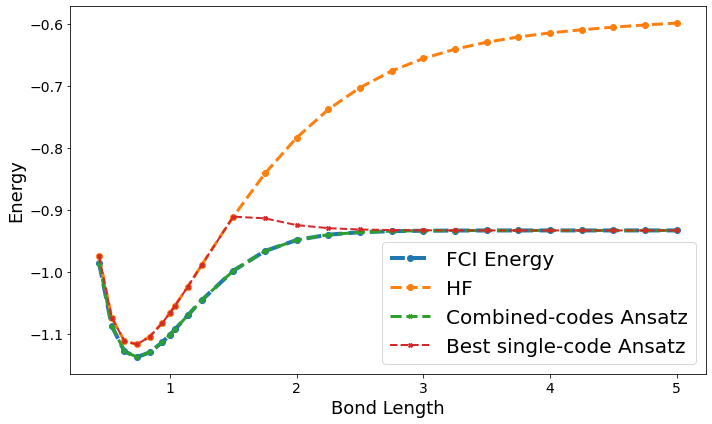

In [10]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=20)
plt.plot(bond_lengths, FCI_eners, marker="o", markersize=6, linestyle="--", linewidth=4, label="FCI Energy")
plt.plot(bond_lengths, HF_ener, marker="o", markersize=6, linestyle="--", linewidth=3, label="HF")
plt.plot(bond_lengths, vqe_eners, marker="X", markersize=4, linestyle="--", linewidth=3, label="Combined-codes Ansatz")
plt.plot(bond_lengths, vqe_with_SCA, marker="X", markersize=4, linestyle="--", linewidth=2, label="Best single-code Ansatz")
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

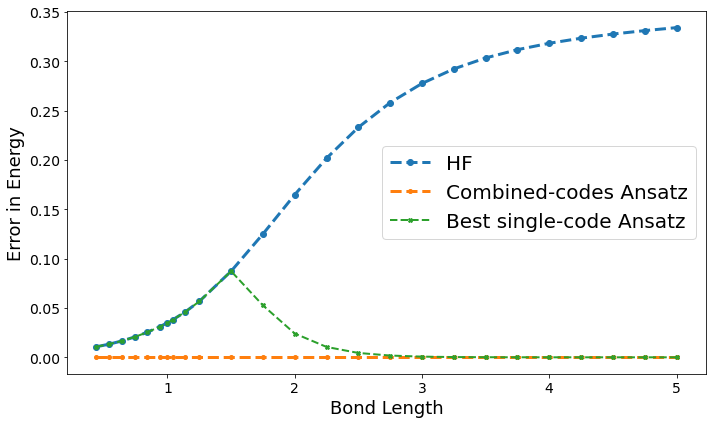

In [11]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=20)
plt.plot(bond_lengths, [-1*(e_f - e_hf) for e_f, e_hf in zip(FCI_eners,HF_ener)], marker="o", markersize=6, linestyle="--", linewidth=3, label="HF")
plt.plot(bond_lengths, [-1*(e_f - e_hf) for e_f, e_hf in zip(FCI_eners,vqe_eners)], marker="o", markersize=4, linestyle="--", linewidth=3, label="Combined-codes Ansatz")
plt.plot(bond_lengths, [-1*(e_f - e_hf) for e_f, e_hf in zip(FCI_eners,vqe_with_SCA)], marker="X", markersize=4, linestyle="--", linewidth=2, label="Best single-code Ansatz")
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Error in Energy', fontsize=18)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()